# **Import the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import the libraries**

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [ ]:
#define paths
hemorrhage = '/content/drive/MyDrive/brainhemorrhage/Hemorrhagic'
non_hemorrhage = "/content/drive/MyDrive/brainhemorrhage/NORMAL"

# Use glob to grab images from path .jpg or jpeg
nonormal_files = glob(hemorrhage + '/*')
normal_files = glob(non_hemorrhage + '/*')

In [ ]:
len(normal_files)

1697

In [ ]:
len(nonormal_files)

4108

# **Pre-processing the images**

In [ ]:
normal_labels = []
nonormal_labels = []

normal_images=[]
nonormal_images=[]

#Image pre-processing

for i in range(850):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('benign')

for i in range(850):
  image = cv2.imread(nonormal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonormal_images.append(image)
  nonormal_labels.append('malignant')

# **Visualization of the images**

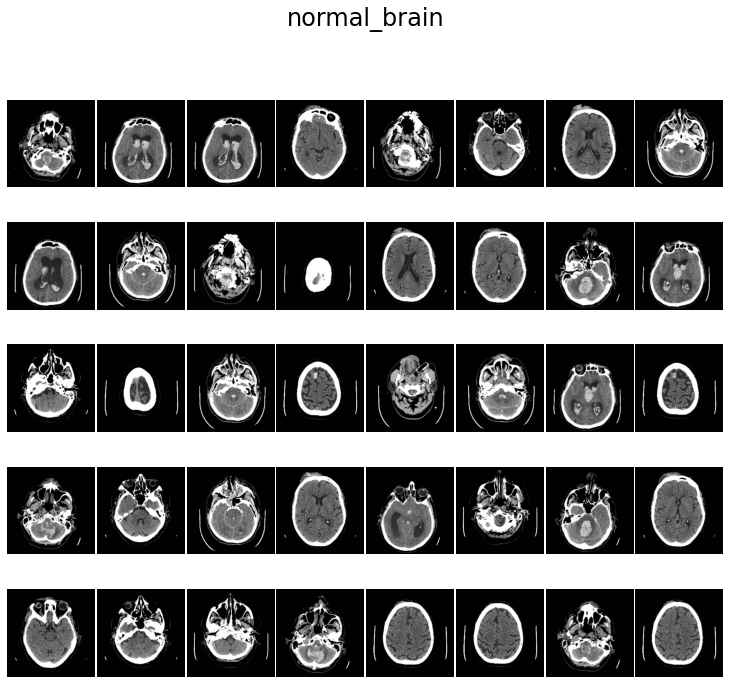

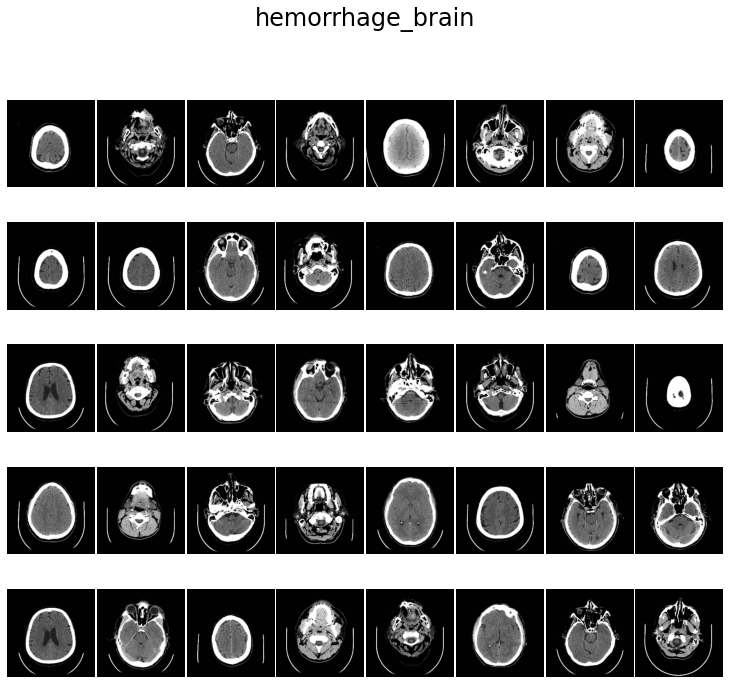

In [ ]:
# look at a random image 
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 10]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images(normal_images, 'normal_brain')
plot_images(nonormal_images, 'hemorrhage_brain') 

# **Normalization**

In [ ]:
# normalize to interval of [0,1]

normal_images = np.array(normal_images) / 255
nonormal_images = np.array(nonormal_images) / 255

# **Splitting the data**

In [ ]:
# split into training and testing
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)
nonormal_x_train, nonormal_x_test, nonormal_y_train, nonormal_y_test = train_test_split(
    nonormal_images, nonormal_labels, test_size=0.2)


X_train = np.concatenate((nonormal_x_train, normal_x_train), axis=0)
X_test = np.concatenate((nonormal_x_test, normal_x_test), axis=0)
y_train = np.concatenate((nonormal_y_train, normal_y_train), axis=0)
y_test = np.concatenate((nonormal_y_test, normal_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

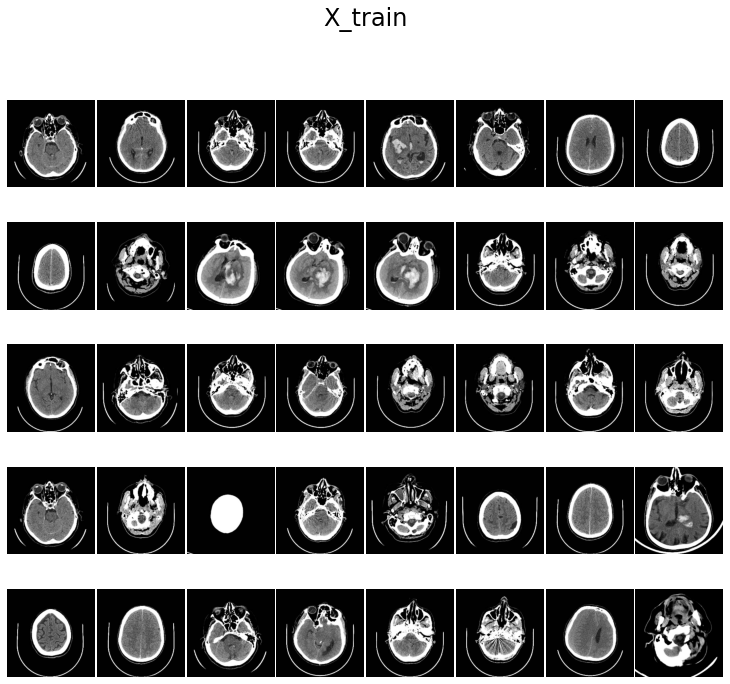

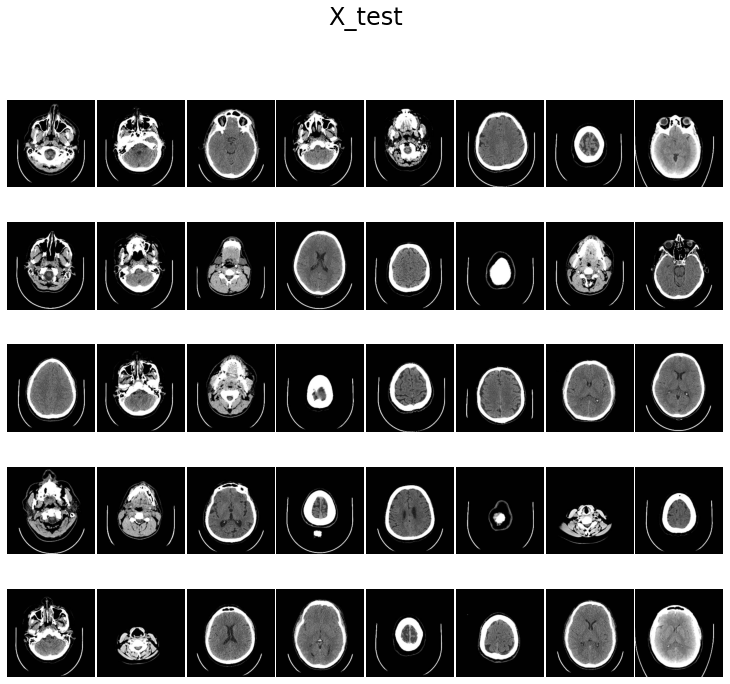

In [ ]:
plot_images(normal_x_train, 'X_train')
plot_images(nonormal_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing normal and NonNormal for X_train and X_test

**The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc.**

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

## **VGG-19**

In [ ]:
from tensorflow.keras.applications import VGG19

vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
!pip install visualkeras 

     |████████████████████████████████| 992 kB 4.3 MB/s 


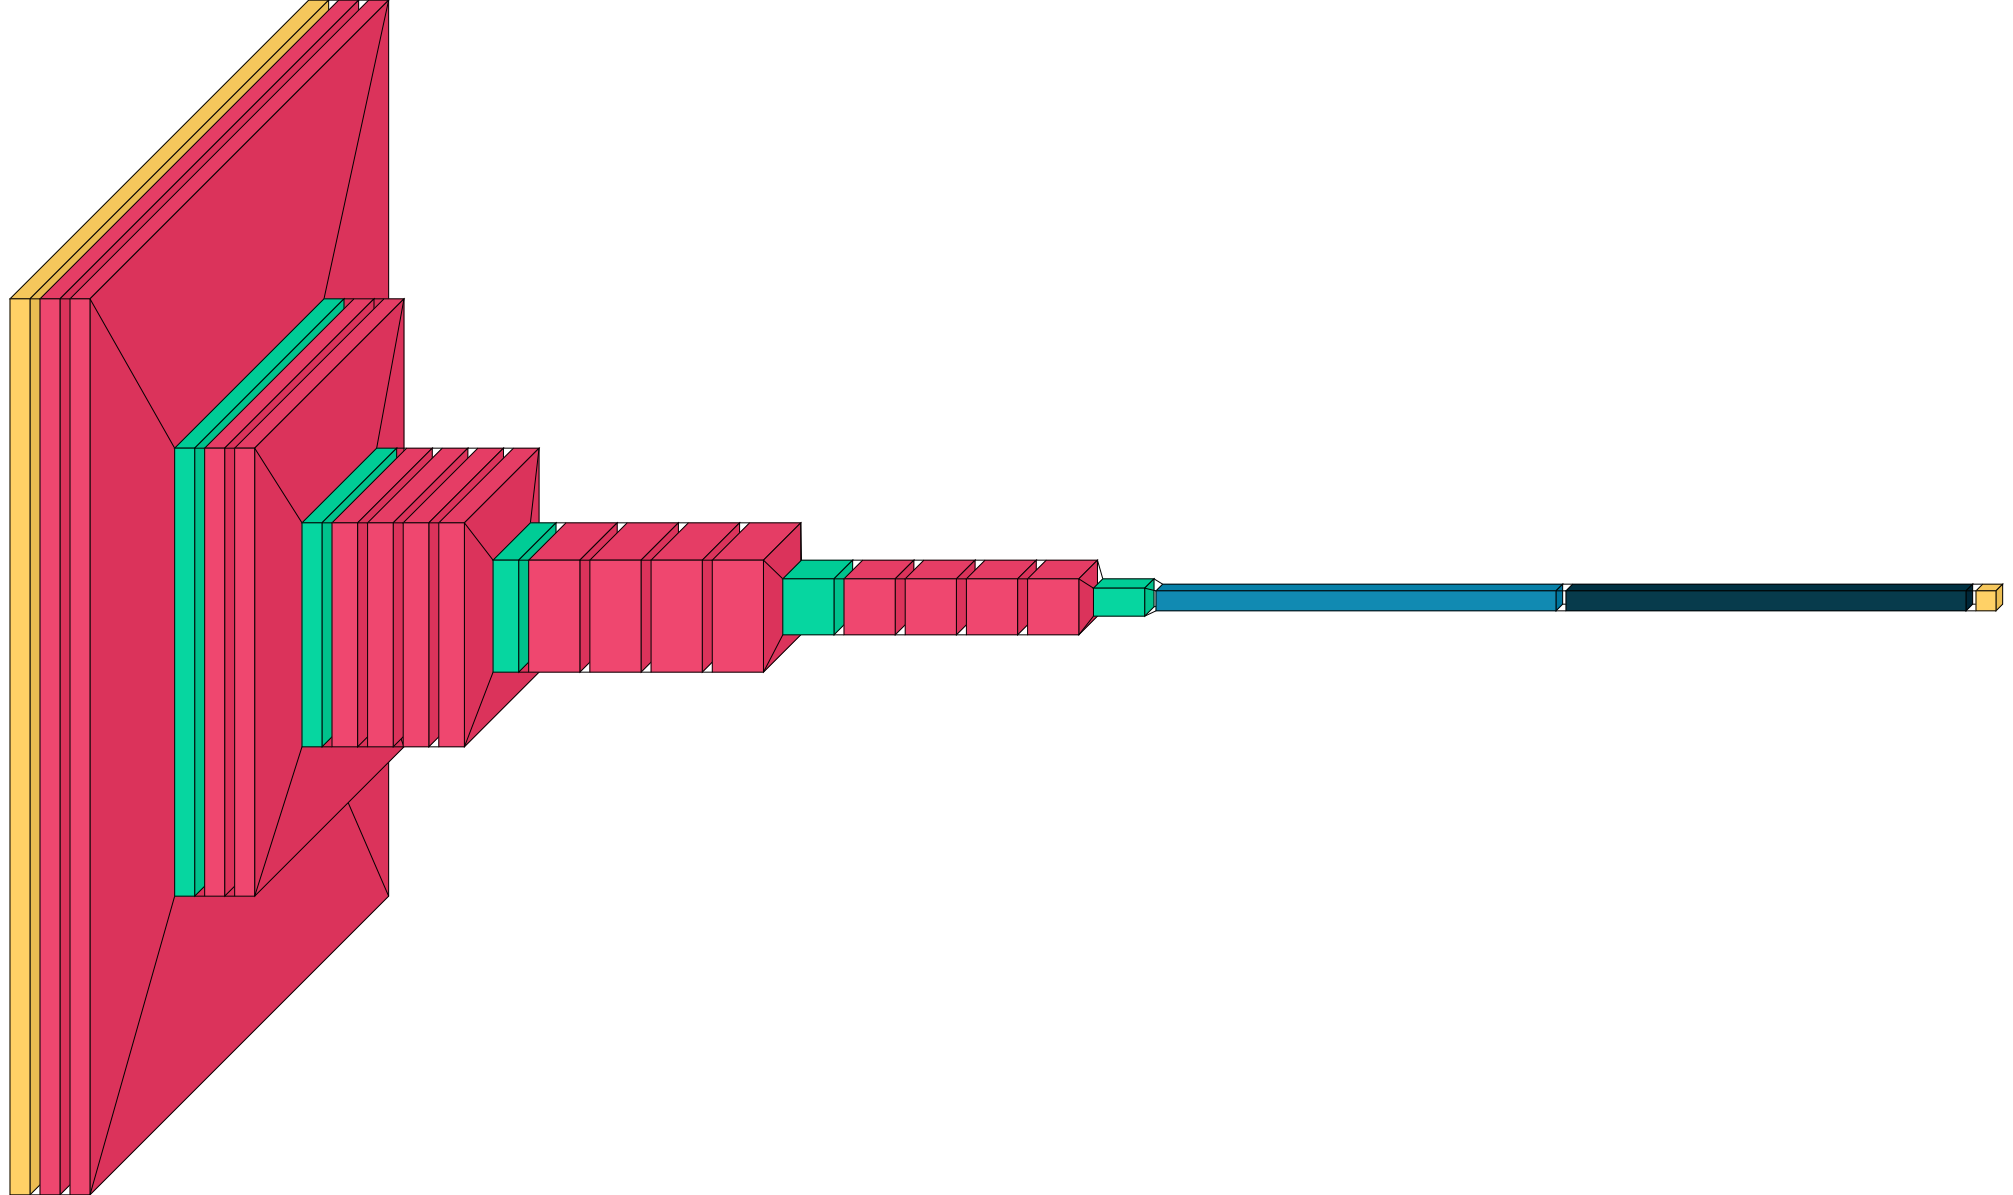

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10) 

Epoch 1/10
42/42 [==============================] - 1077s 25s/step - loss: 1.0325 - accuracy: 0.5537 - val_loss: 0.5359 - val_accuracy: 0.7206
Epoch 2/10
42/42 [==============================] - 1073s 25s/step - loss: 0.6718 - accuracy: 0.6603 - val_loss: 0.4279 - val_accuracy: 0.7853
Epoch 3/10
42/42 [==============================] - 1073s 25s/step - loss: 0.5298 - accuracy: 0.7456 - val_loss: 0.4062 - val_accuracy: 0.7971
Epoch 4/10
42/42 [==============================] - 1074s 25s/step - loss: 0.5518 - accuracy: 0.7206 - val_loss: 0.3378 - val_accuracy: 0.8735
Epoch 5/10
42/42 [==============================] - 1075s 25s/step - loss: 0.5408 - accuracy: 0.7449 - val_loss: 0.3596 - val_accuracy: 0.8441
Epoch 6/10
42/42 [==============================] - 1073s 25s/step - loss: 0.4922 - accuracy: 0.7691 - val_loss: 0.3325 - val_accuracy: 0.8412
Epoch 7/10
42/42 [==============================] - 1072s 25s/step - loss: 0.4711 - accuracy: 0.7860 - val_loss: 0.2747 - val_accuracy: 0.8912

In [ ]:
y_pred = model.predict(X_test, batch_size=32) 

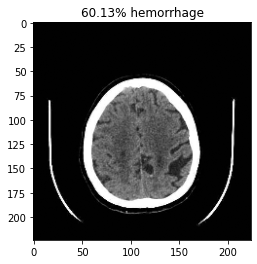

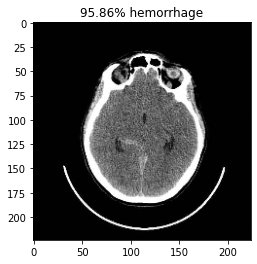

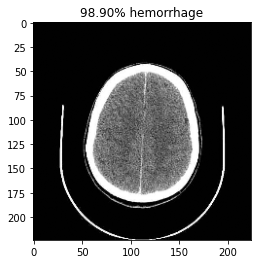

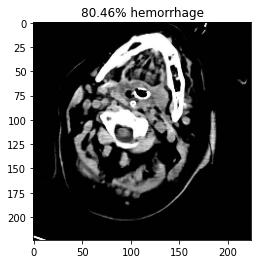

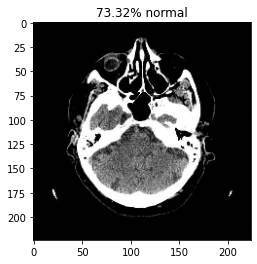

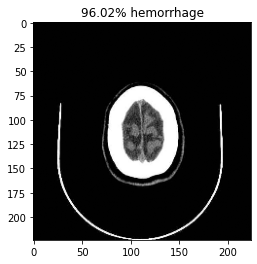

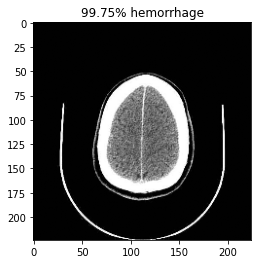

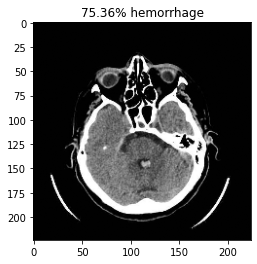

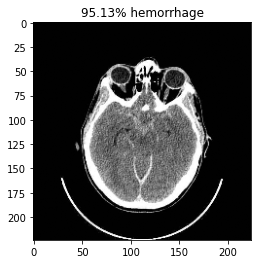

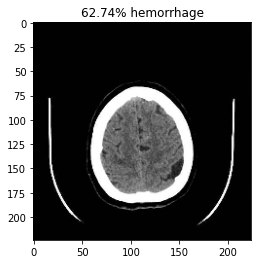

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% hemorrhage')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% normal')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
result=model.evaluate(X_test,y_test)
print(result)

 7/11 [==================>...........] - ETA: 1:23 - loss: 0.3983 - accuracy: 0.8080

In [ ]:
#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
#Plot Confusion Matrix
def plot_confusion_matrix(normalize):
  classes = ['hemorrhage','Normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report

#Classification Report
print(classification_report(y_test_bin, y_pred_bin))

In [ ]:
#Accuracy and Loss Plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

## **ResNet50**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

94781440/94765736 [==============================] - 1s 0us/step


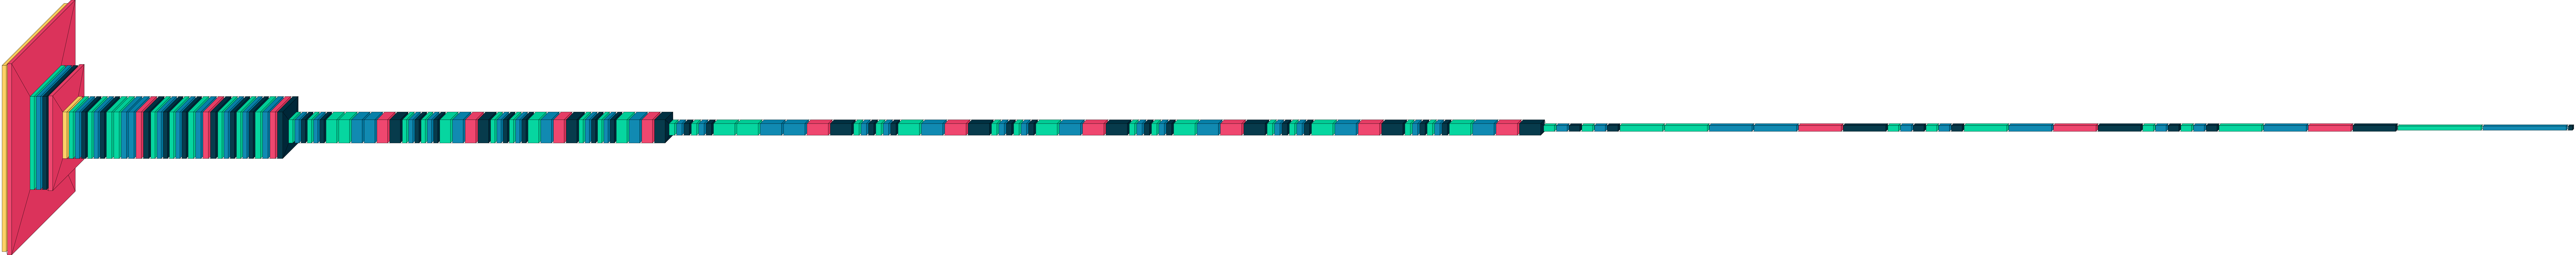

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10) 

Epoch 1/10
42/42 [==============================] - 283s 7s/step - loss: 2.4282 - accuracy: 0.5713 - val_loss: 0.8481 - val_accuracy: 0.6941
Epoch 2/10
42/42 [==============================] - 272s 6s/step - loss: 1.1215 - accuracy: 0.6103 - val_loss: 1.0944 - val_accuracy: 0.6353
Epoch 3/10
42/42 [==============================] - 272s 6s/step - loss: 0.9984 - accuracy: 0.6353 - val_loss: 1.0912 - val_accuracy: 0.6471
Epoch 4/10
42/42 [==============================] - 273s 6s/step - loss: 1.0763 - accuracy: 0.6250 - val_loss: 1.5995 - val_accuracy: 0.6206
Epoch 5/10
42/42 [==============================] - 272s 6s/step - loss: 1.1540 - accuracy: 0.6125 - val_loss: 1.1790 - val_accuracy: 0.6382
Epoch 6/10
42/42 [==============================] - 272s 6s/step - loss: 1.1576 - accuracy: 0.6390 - val_loss: 1.2911 - val_accuracy: 0.6588
Epoch 7/10
42/42 [==============================] - 272s 6s/step - loss: 1.0708 - accuracy: 0.6529 - val_loss: 1.0059 - val_accuracy: 0.6794
Epoch 8/10
42

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

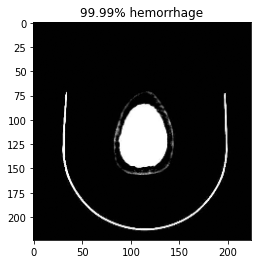

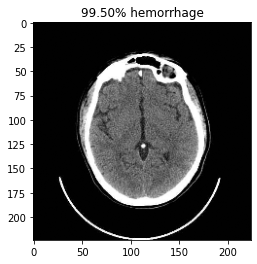

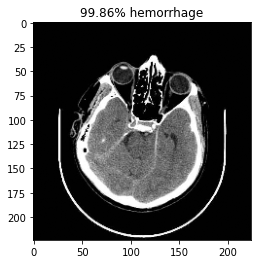

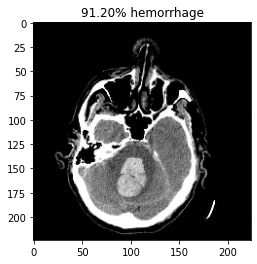

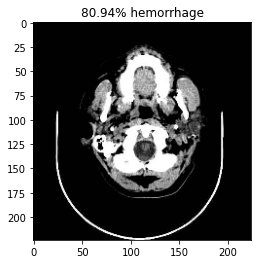

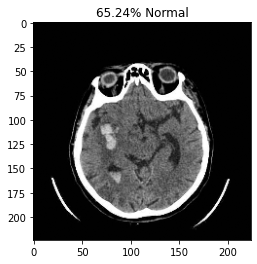

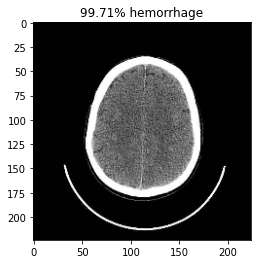

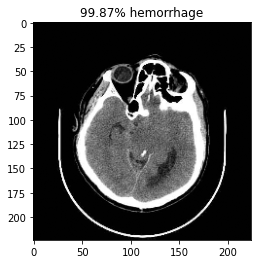

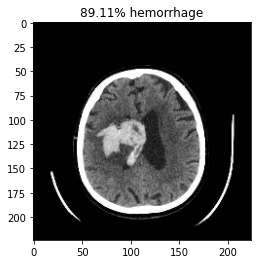

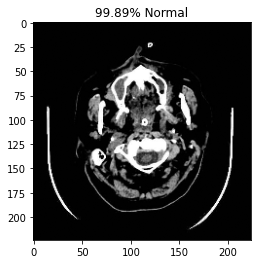

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% hemorrhage')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Normal')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
result=model.evaluate(X_test,y_test)
print(result)

11/11 [==============================] - 52s 5s/step - loss: 0.8601 - accuracy: 0.7324
[0.8601146936416626, 0.7323529124259949]


In [ ]:
from sklearn.metrics import classification_report

#Classification Report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       170
           1       0.72      0.75      0.74       170

    accuracy                           0.73       340
   macro avg       0.73      0.73      0.73       340
weighted avg       0.73      0.73      0.73       340



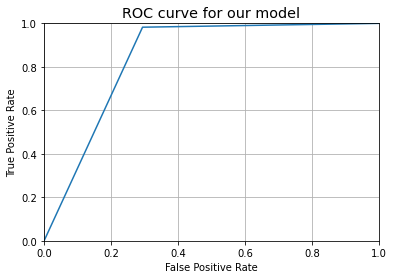

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


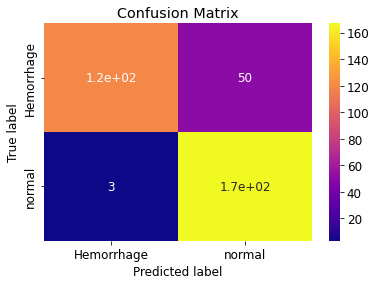

Confusion Matrix with Normalized Values


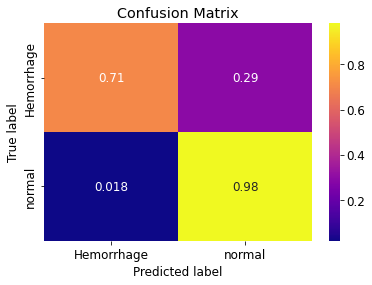

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['Hemorrhage','normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

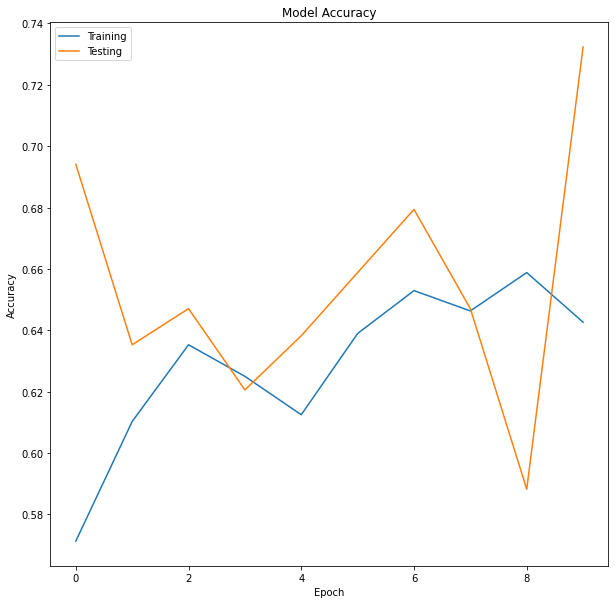

In [ ]:
#Accuracy and Loss Plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

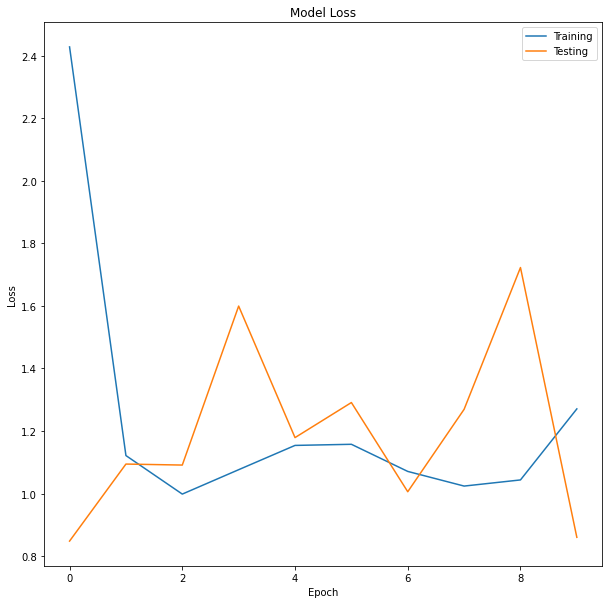

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

## **Inception V3**

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87924736/87910968 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 3.9 MB/s 


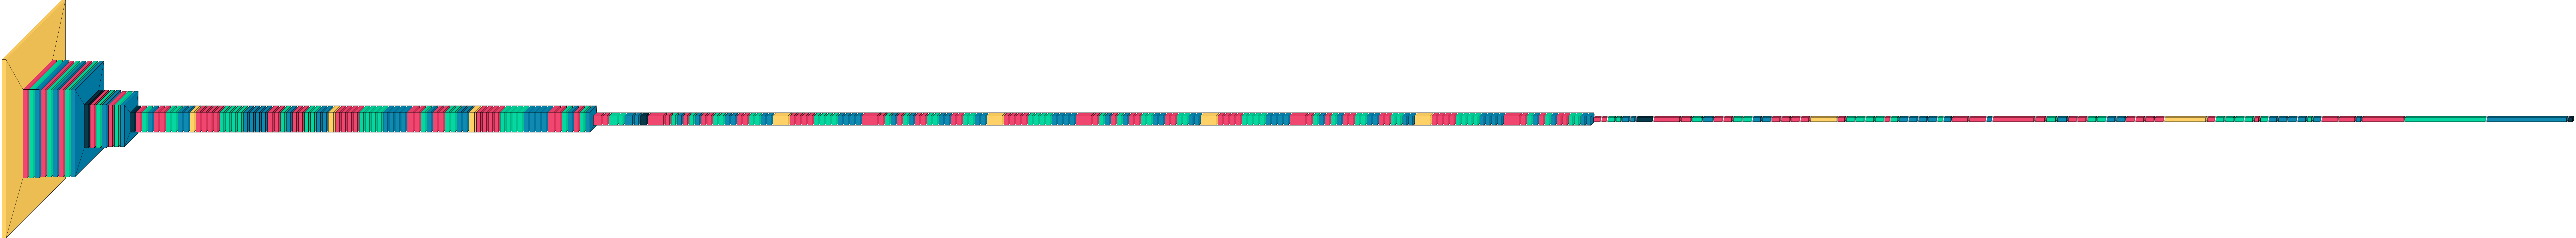

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=10)

Epoch 1/10
42/42 [==============================] - 217s 5s/step - loss: 4.3049 - accuracy: 0.5941 - val_loss: 0.8482 - val_accuracy: 0.7853
Epoch 2/10
42/42 [==============================] - 196s 5s/step - loss: 1.2907 - accuracy: 0.7235 - val_loss: 0.8795 - val_accuracy: 0.7794
Epoch 3/10
42/42 [==============================] - 196s 5s/step - loss: 1.1774 - accuracy: 0.7426 - val_loss: 0.8953 - val_accuracy: 0.7500
Epoch 4/10
42/42 [==============================] - 195s 5s/step - loss: 1.3167 - accuracy: 0.7507 - val_loss: 1.4777 - val_accuracy: 0.7382
Epoch 5/10
42/42 [==============================] - 195s 5s/step - loss: 1.3731 - accuracy: 0.7618 - val_loss: 1.4238 - val_accuracy: 0.7441
Epoch 6/10
42/42 [==============================] - 195s 5s/step - loss: 1.6675 - accuracy: 0.7537 - val_loss: 0.9681 - val_accuracy: 0.8147
Epoch 7/10
42/42 [==============================] - 195s 5s/step - loss: 1.3173 - accuracy: 0.7904 - val_loss: 1.1133 - val_accuracy: 0.7941
Epoch 8/10
42

In [ ]:
y_pred = model.predict(X_test, batch_size=32)

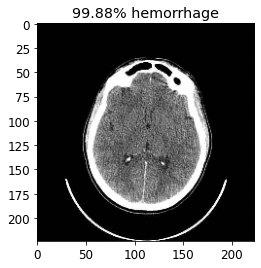

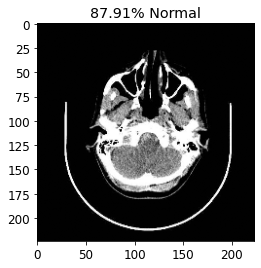

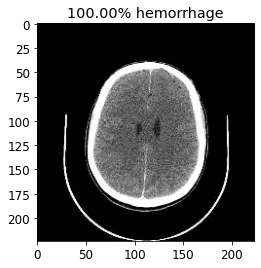

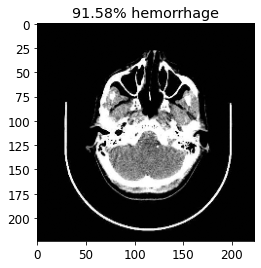

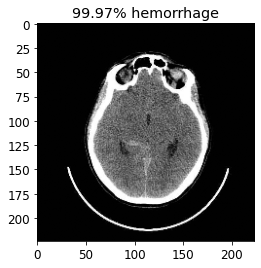

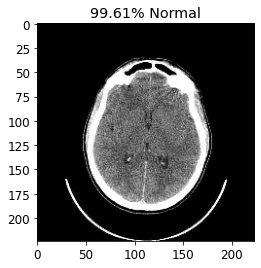

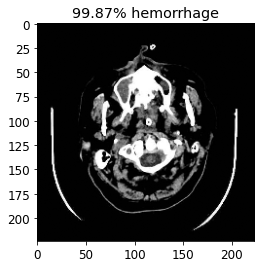

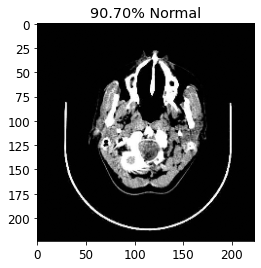

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% hemorrhage')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% Normal')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
result=model.evaluate(X_test,y_test)
print(result)

11/11 [==============================] - 47s 4s/step - loss: 1.9120 - accuracy: 0.7647
[1.9120380878448486, 0.7647058963775635]


In [ ]:
from sklearn.metrics import classification_report

#Classification Report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       170
           1       0.91      0.59      0.71       170

    accuracy                           0.76       340
   macro avg       0.80      0.76      0.76       340
weighted avg       0.80      0.76      0.76       340



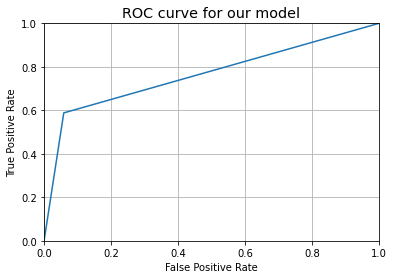

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


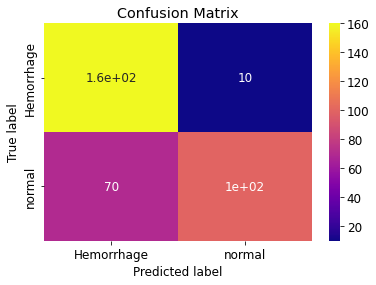

Confusion Matrix with Normalized Values


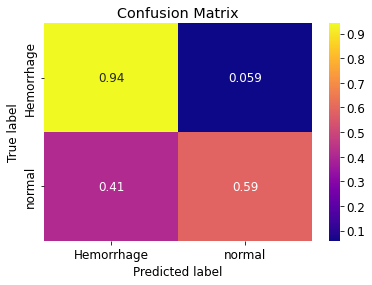

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['Hemorrhage','normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

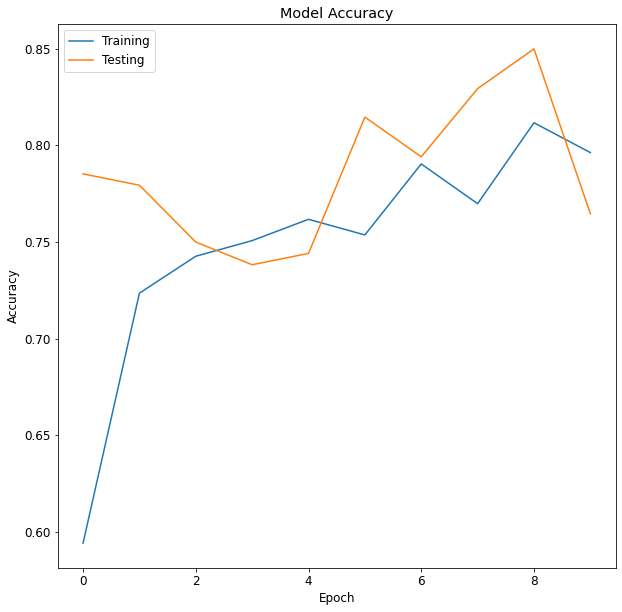

In [ ]:
#Accuracy and Loss Plots
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

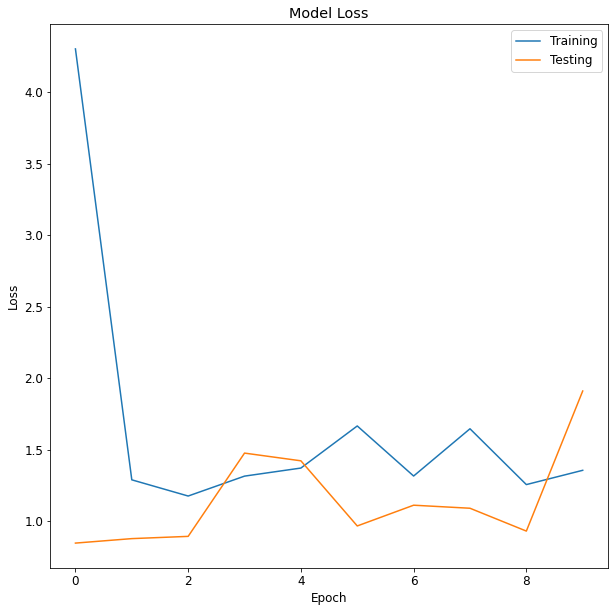

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()